In [24]:
import requests
import datetime
from urllib.parse import urlencode
from os import environ 
from os.path import join
import base64
import urllib.request
import cv2
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np

In [2]:
load_dotenv()

client_id = environ.get('SPOTIFY_CLIENT_ID')
client_secret = environ.get('SPOTIFY_CLIENT_SECRET')

client_id = client_id
client_secret = client_secret

In [25]:
df = pd.read_csv('/home/beres/code/tklein98/crate_scanner/raw_data/albumlist.csv',encoding='latin-1')

In [17]:
df.head()

,Number,Year,album+artist,Album,Artist,Genre,Subgenre
0,1,1967,Sgt. Pepper's Lonely Hearts Club Band The Beatles,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,Rock,"Rock & Roll, Psychedelic Rock"
1,2,1966,Pet Sounds The Beach Boys,Pet Sounds,The Beach Boys,Rock,"Pop Rock, Psychedelic Rock"
2,3,1966,Revolver The Beatles,Revolver,The Beatles,Rock,"Psychedelic Rock, Pop Rock"
3,4,1965,Highway 61 Revisited Bob Dylan,Highway 61 Revisited,Bob Dylan,Rock,"Folk Rock, Blues Rock"
4,5,1965,Rubber Soul The Beatles,Rubber Soul,The Beatles,"Rock, Pop",Pop Rock


In [5]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')
    
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()
    
    def search(self, query=None, operator=None, operator_query=None, search_type='artist' ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower()})
        print(query_params)

        return self.base_search(query_params)

In [6]:
spotify = SpotifyAPI(client_id, client_secret)

In [7]:
spotify.search(query = 'Ok Computer Radiohead', search_type="album")

q=Ok+Computer+Radiohead&type=album


{'albums': {'href': 'https://api.spotify.com/v1/search?query=Ok+Computer+Radiohead&type=album&offset=0&limit=20',
  'items': [{'album_type': 'album',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4Z8W4fKeB5YxbusRsdQVPb'},
      'href': 'https://api.spotify.com/v1/artists/4Z8W4fKeB5YxbusRsdQVPb',
      'id': '4Z8W4fKeB5YxbusRsdQVPb',
      'name': 'Radiohead',
      'type': 'artist',
      'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVPb'}],
    'available_markets': ['AD',
     'AE',
     'AG',
     'AL',
     'AM',
     'AR',
     'AT',
     'AU',
     'AZ',
     'BA',
     'BB',
     'BD',
     'BE',
     'BF',
     'BG',
     'BH',
     'BI',
     'BN',
     'BO',
     'BR',
     'BS',
     'BT',
     'BW',
     'BY',
     'BZ',
     'CA',
     'CH',
     'CL',
     'CM',
     'CO',
     'CR',
     'CV',
     'CW',
     'CY',
     'CZ',
     'DE',
     'DK',
     'DM',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FJ'

In [44]:
%%time
spotify.search(query = 'Ok Computer Radiohead', search_type="album")['albums']['items'][0]['images']

q=Ok+Computer+Radiohead&type=album
CPU times: user 67.7 ms, sys: 0 ns, total: 67.7 ms
Wall time: 699 ms


[{'height': 640,
  'url': 'https://i.scdn.co/image/ab67616d0000b273c8b444df094279e70d0ed856',
  'width': 640},
 {'height': 300,
  'url': 'https://i.scdn.co/image/ab67616d00001e02c8b444df094279e70d0ed856',
  'width': 300},
 {'height': 64,
  'url': 'https://i.scdn.co/image/ab67616d00004851c8b444df094279e70d0ed856',
  'width': 64}]

In [45]:
image = spotify.search(query = 'Ok Computer Radiohead', search_type="album")['albums']['items'][0]['images'][1]['url']

q=Ok+Computer+Radiohead&type=album


In [10]:
image

'https://i.scdn.co/image/ab67616d00001e02c8b444df094279e70d0ed856'

In [11]:
test = urllib.request.urlretrieve(image)

In [12]:
test

('/tmp/tmpmuziorbh', <http.client.HTTPMessage at 0x7fca0f8b0fa0>)

In [13]:
# Since cv2 reads colors as BRG, this converts it to RGB 

img = cv2.imread(test[0])[:,:,::-1]

In [14]:
img1

NameError: name 'img1' is not defined

TypeError: Image data of dtype object cannot be converted to float

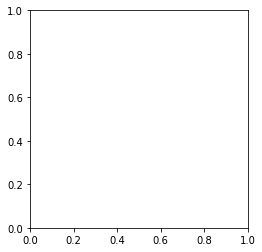

In [46]:
plt.imshow(img1)

In [34]:
images = []
for album in df['album+artist']:
        try:
            image = spotify.search(query = album, search_type="album")['albums']['items'][0]['images'][1]['url']
            img1 = urllib.request.urlretrieve(image)
            img2 = cv2.imread(img1[0])[:,:,::-1]
            images.append([album, img2.copy()])
        except:
            pass

q=Sgt.+Pepper%27s+Lonely+Hearts+Club+Band+The+Beatles&type=album
q=Pet+Sounds+The+Beach+Boys&type=album
q=Revolver+The+Beatles&type=album
q=Highway+61+Revisited+Bob+Dylan&type=album
q=Rubber+Soul+The+Beatles&type=album
q=What%27s+Going+On+Marvin+Gaye&type=album
q=Exile+on+Main+St.+The+Rolling+Stones&type=album
q=London+Calling+The+Clash&type=album
q=Blonde+on+Blonde+Bob+Dylan&type=album
q=The+Beatles++%22The+White+Album%22++The+Beatles&type=album
q=The+Sun+Sessions+Elvis+Presley&type=album
q=Kind+of+Blue+Miles+Davis&type=album
q=The+Velvet+Underground+%26+Nico+The+Velvet+Underground&type=album
q=Abbey+Road+The+Beatles&type=album
q=Are+You+Experienced+The+Jimi+Hendrix+Experience&type=album
q=Blood+on+the+Tracks+Bob+Dylan&type=album
q=Nevermind+Nirvana&type=album
q=Born+to+Run+Bruce+Springsteen&type=album
q=Astral+Weeks+Van+Morrison&type=album
q=Thriller+Michael+Jackson&type=album
q=The+Great+Twenty_Eight+Chuck+Berry&type=album
q=The+Complete+Recordings+Robert+Johnson&type=album
q=John+L

q=Natty+Dread+Bob+Marley+%26+The+Wailers&type=album
q=Fleetwood+Mac+Fleetwood+Mac&type=album
q=Red+Headed+Stranger+Willie+Nelson&type=album
q=The+Immaculate+Collection+Madonna&type=album
q=The+Stooges+The+Stooges&type=album
q=Fresh+Sly+%26+The+Family+Stone&type=album
q=So+Peter+Gabriel&type=album
q=Buffalo+Springfield+Again+Buffalo+Springfield&type=album
q=Happy+Trails+Quicksilver+Messenger+Service&type=album
q=From+Elvis+in+Memphis+Elvis+Presley&type=album
q=Fun+House+The+Stooges&type=album
q=The+Gilded+Palace+of+Sin+The+Flying+Burrito+Brothers&type=album
q=Dookie+Green+Day&type=album
q=Transformer+Lou+Reed&type=album
q=Blues+Breakers+With+Eric+Clapton++%22The+Beano+Album%22++John+Mayall+%26+The+Bluesbreakers&type=album
q=Nuggets%3A+Original+Artyfacts+From+the+First+Psychedelic+Era%2C+1965-1968+Various+Artists&type=album
q=Murmur+R.E.M.&type=album
q=The+Best+of+Little+Walter+Little+Walter&type=album
q=Is+This+It+The+Strokes&type=album
q=Highway+to+Hell+AC%2FDC&type=album
q=The+Downwar

q=Substance+1987+New+Order&type=album
q=L.A.+Woman+The+Doors&type=album
q=Rage+Against+the+Machine+Rage+Against+the+Machine&type=album
q=American+Recordings+Johnny+Cash&type=album
q=Ray+of+Light+Madonna&type=album
q=Eagles+Eagles&type=album
q=Louder+Than+Bombs+The+Smiths&type=album
q=Mott+Mott+the+Hoople&type=album
q=Whatever+People+Say+I+Am%2C+That%27s+What+I%27m+Not+Arctic+Monkeys&type=album
q=Reggatta+de+Blanc+The+Police&type=album
q=Volunteers+Jefferson+Airplane&type=album
q=Siren+Roxy+Music&type=album
q=Late+for+the+Sky+Jackson+Browne&type=album
q=Post+Bjork&type=album
q=The+Ultimate+Collection%3A+1948-1990+John+Lee+Hooker&type=album
q=+What%27s+the+Story++Morning+Glory%3F+Oasis&type=album
q=CrazySexyCool+TLC&type=album
q=Funky+Kingston+Toots+%26+The+Maytals&type=album
q=The+Smile+Sessions+The+Beach+Boys&type=album
q=The+Modern+Lovers+The+Modern+Lovers&type=album
q=More+Songs+About+Buildings+and+Food+Talking+Heads&type=album
q=A+Quick+One+The+Who&type=album
q=%22Love+and+Theft%22+

In [35]:
df = pd.DataFrame(images)
df.to_csv('images.csv')

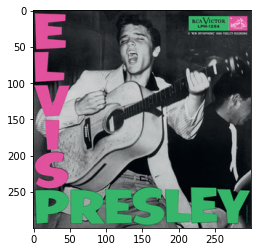

In [41]:
plt.imshow(images[50][1])

In [40]:
len(images)

461

In [42]:
images

[["Sgt. Pepper's Lonely Hearts Club Band The Beatles",
  array([[[146, 217, 247],
          [147, 218, 248],
          [146, 217, 247],
          ...,
          [175, 225, 250],
          [178, 226, 249],
          [180, 226, 249]],
  
         [[144, 215, 245],
          [146, 217, 247],
          [146, 217, 247],
          ...,
          [169, 223, 247],
          [173, 225, 247],
          [174, 225, 246]],
  
         [[144, 215, 245],
          [146, 217, 247],
          [147, 218, 248],
          ...,
          [168, 224, 247],
          [171, 226, 247],
          [173, 225, 247]],
  
         ...,
  
         [[ 60,  56,  45],
          [ 60,  68,  53],
          [ 57,  67,  43],
          ...,
          [ 83,  80,  63],
          [ 75,  72,  57],
          [ 72,  68,  56]],
  
         [[ 76,  78,  67],
          [ 50,  58,  47],
          [ 38,  49,  19],
          ...,
          [ 74,  71,  56],
          [ 71,  67,  55],
          [ 70,  66,  55]],
  
         [[ 54,  60,  5